# Задание 3

In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from catalyst import utils

from torchsummary import summary

sns.set(style="darkgrid", font_scale=1.4)
%matplotlib inline

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [2]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features, requires_grad=True))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features, requires_grad=True)) # YOUR CODE GOES HERE

    def forward(self, x):
      x =  x @ self.weights # YOUR CODE GOES HERE
      if self.bias:
          x += self.bias_term # YOUR CODE GOES HERE
      return x

### Датасет

Давайте сгенерируем датасет и посмотрим на него!

In [3]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

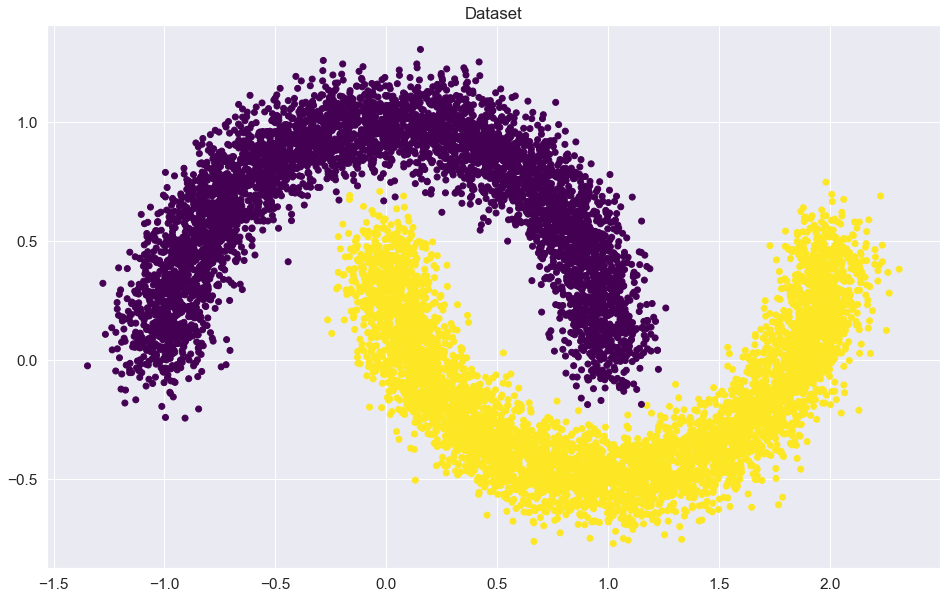

In [4]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.


In [6]:
X_train_t = torch.tensor(X_train, dtype=torch.float32) # YOUR CODE GOES HERE
y_train_t = torch.tensor(y_train, dtype=torch.float32) # YOUR CODE GOES HERE
X_val_t = torch.tensor(X_val, dtype=torch.float32) # YOUR CODE GOES HERE
y_val_t = torch.tensor(y_val, dtype=torch.float32) # YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [8]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [9]:
summary(linear_regression, (2, ))

Layer (type:depth-idx)                   Output Shape              Param #
└─LinearRegression: 0-1                  [-1, 1]                   3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
└─LinearRegression: 0-1                  [-1, 1]                   3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

**Вопрос 1** Сколько обучаемых параметров у получившейся модели?

**Ответ: 3**

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [10]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    utils.set_global_seed(42 + epoch)
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch) # YOUR CODE GOES HERE
        loss = loss_function(outp, y_batch.reshape((y_batch.shape[0], -1))) # YOUR CODE GOES HERE
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.exp(outp) / torch.exp(outp).sum(dim=1, keepdims=True) # YOUR CODE GOES HERE
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 7500
Batch accuracy: 0.484375
Iteration: 15000
Batch accuracy: 0.484375
Iteration: 22500
Batch accuracy: 0.484375
Iteration: 30000
Batch accuracy: 0.484375
Iteration: 37500
Batch accuracy: 0.484375
Iteration: 45000
Batch accuracy: 0.484375
Iteration: 52500
Batch accuracy: 0.484375
Iteration: 60000
Batch accuracy: 0.484375
Iteration: 67500
Batch accuracy: 0.484375
Iteration: 75000
Batch accuracy: 0.484375
Iteration: 82500
Batch accuracy: 0.484375
Iteration: 90000
Batch accuracy: 0.484375

Iteration: 90047.Convergence. Stopping iterations.


**Вопрос 2**

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**

### Визуализируем результаты

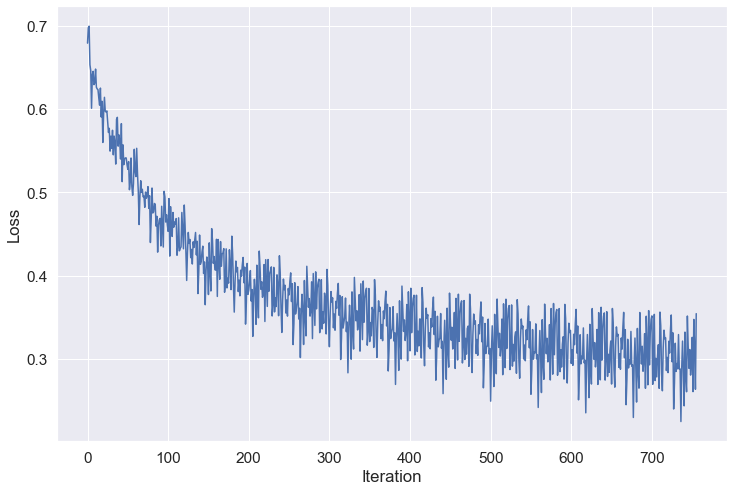

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

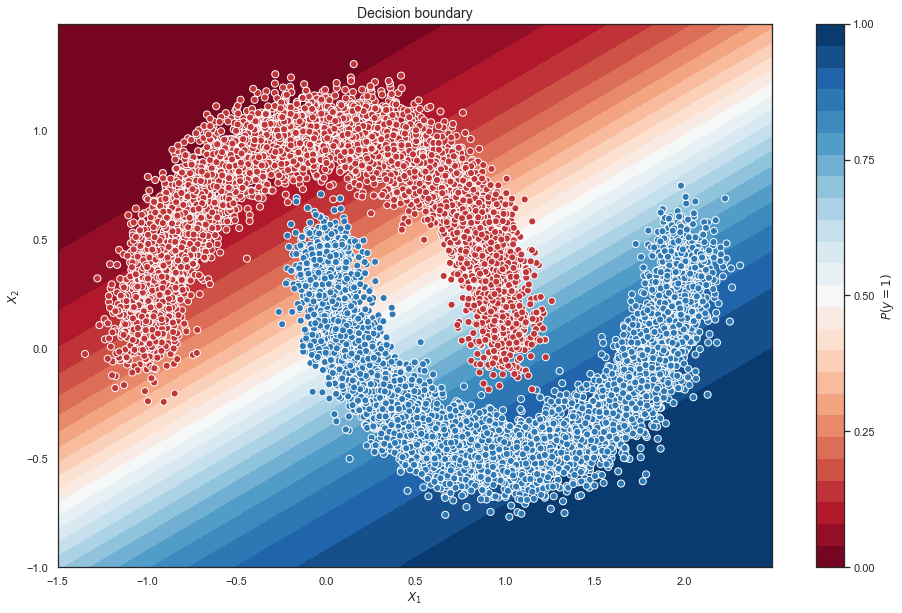

In [12]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [13]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [14]:
from sklearn.metrics import accuracy_score

# YOUR CODE GOES HERE
accuracy_score(y_val_t, predict(val_dataloader, linear_regression))

0.862

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ: 0.862** 

### MNIST

In [15]:
import os
import torchvision
from catalyst.contrib.datasets import MNIST

transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

train_dataset = MNIST(root=os.getcwd(), train=True, download=True, transform=transform)
val_dataset = MNIST(root=os.getcwd(), train=False, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2) # YOUR CODE GOES HERE
valid_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=2) # YOUR CODE GOES HERE

In [16]:
class Identical(nn.Module):
    def forward(self, x):
        return x

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)

In [37]:
activation = Identical

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [23]:
from tqdm import tqdm

In [40]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in tqdm(dataloader):
            if k == "train":
                # YOUR CODE GOES HERE
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                 # YOUR CODE GOES HERE
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum() # YOUR CODE GOES HERE
            all = y_batch.size(0) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                 # YOUR CODE GOES HERE
                 # YOUR CODE GOES HERE
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8665666666666667


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.8703571428571428


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.8912333333333333


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.893


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.8965833333333333


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.8979428571428572


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9003666666666666


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9007714285714286


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9032666666666667


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9024714285714286


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9044


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9055285714285715


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9057


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9051714285714286


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9058166666666667


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9070571428571429


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9068333333333334


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9077428571428572


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9066833333333333


100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:03<00:00, 637.47it/s]

Loader: valid. Accuracy: 0.9085


Попробуйте разные функции активации. Позапускайте ячейки сверху несколько раз изменив функции активации. После каждого обучения запустите одну из ячеек снизу. Таким образом мы получим график accuracy/epoch для каждой функции активации.

In [41]:
plain_accuracy = accuracy["valid"]

In [30]:
relu_accuracy = accuracy["valid"]

In [35]:
leaky_relu_accuracy = accuracy["valid"]

In [25]:
elu_accuracy = accuracy["valid"]

In [47]:
np.max(leaky_relu_accuracy), np.max(elu_accuracy), np.max(relu_accuracy)

(0.9800571428571428, 0.9810285714285715, 0.9791285714285715)

### Accuracy

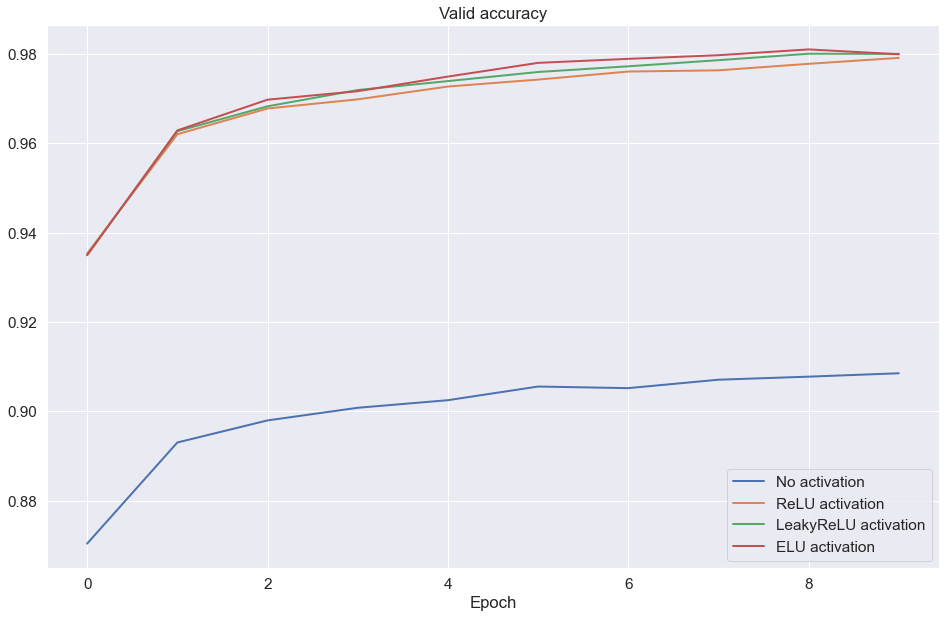

In [42]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

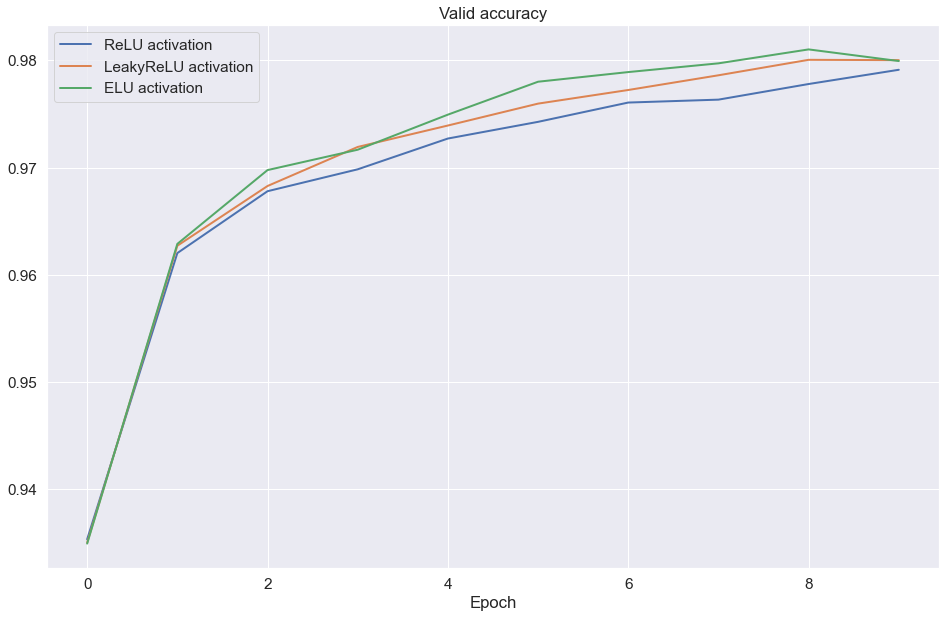

In [43]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4** Какая из активаций показала наивысший `accuracy`?

**Ответ: ELU**

## Сверточные слои

### Ядра

In [66]:
import wget
wget.download('https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg', 'sample_photo.jpg')

100% [..............................................................................] 49337 / 49337

'sample_photo.jpg'

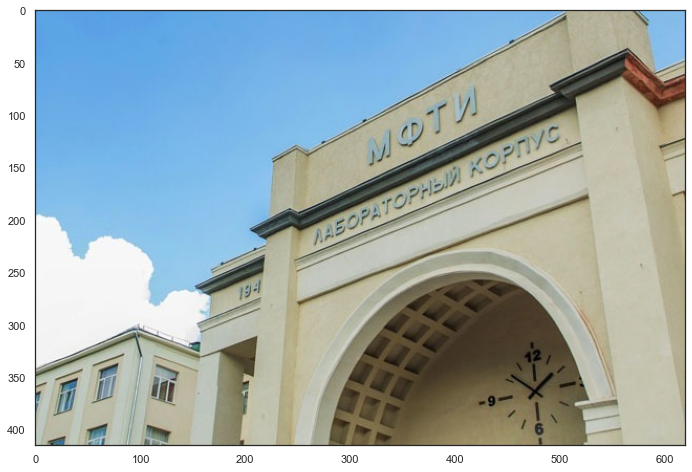

In [73]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [115]:
kernel = torch.tensor([
  [0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

In [116]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)


kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


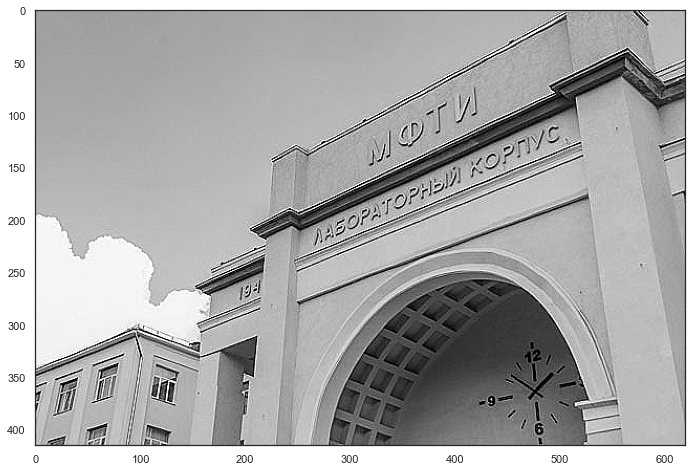

In [117]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5** Как вы считаете, как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие - Е

2) Увеличение резкости - Д

3) Тождественное преобразование - А

4) Выделение вертикальных границ

5) Выделение горизонтальных границ - Б

6) Выделение границ - В

**Ответ:**

### LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Давайте посмотрим на архитектуру, предложенную еще в 1998 году!

In [118]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [119]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [124]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42+epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in tqdm(dataloader):
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum() # YOUR CODE GOES HERE
            all = y_batch.size(0) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                 # YOUR CODE GOES HERE
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.98465


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9838714285714286


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.9873166666666666


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9853428571428572


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9889666666666667


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9883428571428572


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9904333333333334


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9893714285714286


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9912833333333333


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9905142857142857


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.99195


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9912285714285715


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.99225


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9916428571428572


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9929


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9917


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.99315


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9922428571428571


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9929333333333333


100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 409.20it/s]

Loader: valid. Accuracy: 0.9920857142857142


In [125]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

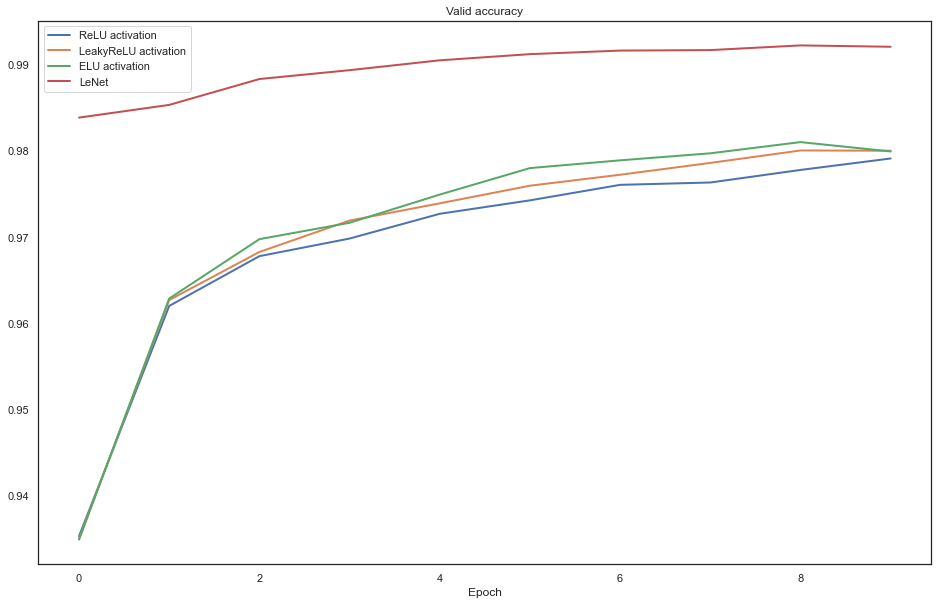

In [126]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**